In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
df_2014 = pd.read_csv("../data/raw/CDSarchive201403/Reference_CCAProfiles_2008_2012.csv")
df_2015 = pd.read_csv("../data/raw/CDSarchive201508/Reference_countyProfiles_2009_2013.csv")
df_2016 = pd.read_csv("../data/raw/CDSarchive201606/Reference_CCAProfiles_2010_2014.csv")
df_2017 = pd.read_csv("../data/raw/CDSarchive201706/Reference_CCAProfiles_2011_2015.csv")
df_2018 = pd.read_csv("../data/raw/CDSarchive201811/Reference_CCAProfiles_2012_2016.csv")
df_2019 = pd.read_csv("../data/raw/CDSarchive201906/Reference_CCAProfiles_2013_2017.csv")
df_2020 = pd.read_csv("../data/raw/CDSarchive202007/ReferenceCCAProfiles20142018.csv")

In [7]:
# starting analysis with these columns
need_columns= ['GEOG', '2000_POP', '2010_POP', 'TOT_POP', 'YEAR', 'MEDINC', 'EMP', 'IN_LBFRC', 'OWN_OCC_HU', 
               'RENT_OCC_HU', 'VAC_HU', 'TOT_HH', 'HU_SNG_DET', 'HU_SNG_ATT', 'HU_2UN', 'HU_3_4UN', 'HU_GT_5UN', 
               'MED_HA', 'BR_0_1', 'BR_2', 'BR_3', 'BR_4', 'BR_5','WHITE', 'HISP', 'BLACK', 'ASIAN', 'OTHER']

In [458]:
#df_2020.drop(df_2020[df_2020['GEOG'].isna()].index, inplace=True)
#df_2020['HU_GT_5UN'] =  df_2020['HU_5_9UN'] + df_2020['HU_GT_19UN']

In [8]:
all_dfs ={2014: df_2014, 
          2015: df_2015, 
          2016: df_2016, 
          2017: df_2017,
          2018: df_2018,
          2019: df_2019,
          2020: df_2020}

years = [x for x in range(2014,2021)]

### Initial data cleaning

In [11]:
rename_columns = {"CCA": "GEOG",
                 'RNT_OCC_HU': 'RENT_OCC_HU',
                  'MED_INC' : 'MEDINC'
                 }
df_list = []
for y in years:
    df = all_dfs[y]
    ycol = [y]*len(df)
    df['YEAR'] = ycol
    df = df.rename(columns=rename_columns)
    
    c = df.columns.to_list()
    df = df.drop(columns=list(set(c) - set(need_columns)))

    df_list.append(df)
    df.to_csv("../data/clean/{}.csv".format(y))

In [461]:
df_all_data = pd.concat(df_list)
df_all_data.shape

(539, 28)

### Feature generation

##### predictor columns
- unemployment rate
- race
- median income
- income index relative to city overall?
- % rented housing units
- % owned housing units
- % or number vacant
- housing type
- housing age
- housing size


In [321]:
employment_rate = df_all_data['EMP']/df_all_data['IN_LBFRC']
df_all_data['EMP_RATE'] = employment_rate

In [322]:
race_columns = ['WHITE', 'HISP', 'BLACK', 'ASIAN', 'OTHER']

for race in race_columns:
    pct = df_all_data[race]/df_all_data['TOT_POP']
    name = race + "_PCT"
    df_all_data[name] = pct

In [323]:
rnt_own_columns = ['OWN_OCC_HU', 'RENT_OCC_HU', 'VAC_HU']

for r in rnt_own_columns:
    pct = df_all_data[r]/df_all_data['TOT_HH']
    name = r + "_PCT"
    df_all_data[name] = pct

In [454]:
df_all_data.to_csv("clean_data.csv")

### Exploring the data

In [410]:
df_inc_chg = pd.DataFrame({'INC_CHG': df_2020['MEDINC'] - df_2014['MEDINC'],
                          'POP_CHG': df_2020['TOT_POP']- df_2014['TOT_POP']}).sort_values(by='INC_CHG')

In [427]:
from sklearn.linear_model import LinearRegression

x = df_inc_chg['INC_CHG'].to_numpy().reshape(-1,1)
y = df_inc_chg['POP_CHG'].to_numpy()#.reshape(1,-1)

pop_model = LinearRegression()
pop_model.fit(x,y)
y_predict = pop_model.predict(x)

Text(0.5, 1.0, 'Population change as function of \nincome change, by neighborhood')

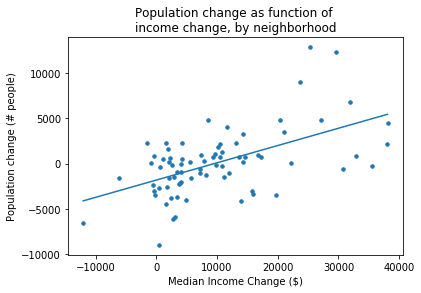

In [453]:
plt.scatter(df_inc_chg['INC_CHG'], df_inc_chg['POP_CHG'], s=12)
plt.plot(x, y_predict)
plt.xlabel("Median Income Change ($)")
plt.ylabel("Population change (# people)")
plt.title("Population change as function of \nincome change, by neighborhood")